## Dimensionality reduction, Latent Variable Models and (Probabilistic) Principal Component Analysis

In this lab, you will implement and analyze one classic dimensionality reduction method (PCA) and it's corresponding probabilistic interpretation. 

By the end of this lab, you will be able to 
- implement PCA from zero, using linear algebra
- extend PCA to be probabilistic

In [1]:
from functools import partial

import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rc
from tqdm.notebook import tqdm

colab = "google.colab" in str(get_ipython())
preamble = r"""\renewcommand{\familydefault}{\sfdefault}\usepackage{sansmath}
\usepackage{FiraSans}\sansmath\usepackage{amsmath}\usepackage{bm}"""

rc("font", **{"family": "sans-serif", "sans-serif": "DejaVu Sans"})
rc("text", **{"usetex": not colab, "latex.preamble": preamble})
rc("figure", **{"dpi": 200, "figsize": [5, 3]})
rc(
    "axes",
    **{"spines.right": False, "spines.top": False, "xmargin": 0.0, "ymargin": 0.05}
)

plt.rcParams.update(
    {
        "lines.color": "white",
        "patch.edgecolor": "white",
        "text.color": "white",
        "axes.facecolor": "#21252B",
        "axes.edgecolor": "white",
        "axes.labelcolor": "white",
        "xtick.color": "white",
        "ytick.color": "white",
        "grid.color": "white",
        "figure.facecolor": "#21252B",
        "figure.edgecolor": "#21252B",
        "savefig.facecolor": "#21252B",
        "savefig.edgecolor": "#21252B",
    }
)

Let's start to generate the data that we will be using in the notebook (we will also have some labels just to simplify visualization).

In [2]:
def generate_data(N):
    rng = iter(jax.random.split(jax.random.PRNGKey(1), 10))
    x0 = jax.random.uniform(next(rng), shape=(N // 2,))  # + 0.1
    x1 = jax.random.uniform(next(rng), shape=(N // 2,)) * 4 - 2
    x2 = 0.5 * jax.random.normal(next(rng), shape=(len(x0),))
    x10 = jax.random.uniform(next(rng), shape=(N // 2,)) * -1  # - 0.1
    x11 = jax.random.uniform(next(rng), shape=(N // 2,)) * 4 - 2
    x12 = 0.5 * jax.random.normal(next(rng), shape=(len(x10),))

    X = jnp.stack([x0, x10, x1, x11, x2, x12]).reshape(3, N).T
    return X  # , jnp.concatenate([jnp.zeros(N // 2), jnp.ones(N // 2)])


X = generate_data(250)

In [3]:
from ipywidgets import IntSlider, interact


def animate(angle):
    fig = plt.figure(figsize=[5, 5])
    config = dict(edgecolor="black", linewidth=1, zorder=10)
    ax = fig.add_subplot(projection="3d")
    ax.scatter(*X.T, facecolor="tab:red", **config)
    ax.view_init(angle, azim=angle)
    ax.tick_params(axis="both", which="major", pad=1)
    ax.set_xlabel(r"$x_0$")
    ax.set_ylabel(r"$x_1$")
    ax.set_zlabel(r"$x_2$")
    ax.set_title(r"Observed space $X$")
    ax.set_zlim(-3, 3)
    plt.show()


interact(animate, angle=IntSlider(min=0, max=360, step=1, value=20));

interactive(children=(IntSlider(value=20, description='angle', max=360), Output()), _dom_classes=('widget-inte…

### Review of PCA 

The most common derivation of PCA is in terms of a standardized linear projection which
maximizes the variance in the projected space. For a set of observed $d$-dimensional data vectors 
$\boldsymbol X = \{\boldsymbol x_n\}_{n=1}^N$, the $q$ principal axes $\boldsymbol w_j$, for $j=1,...,Q$ are
those orthonormal axes onto which the retained variance under projection is maximal. It can
be shown that the vectors $\boldsymbol w_j$ are given by the $q$ dominant eigenvectors (i.e. those with the
largest associated eigenvalues $\lambda_j$) of the sample covariance matrix $\boldsymbol S = \frac 1N \boldsymbol X^\top\boldsymbol X$, such that $\boldsymbol S\boldsymbol w_j = \lambda_j \boldsymbol w_j$. 
The $q$ principal components of the
observed vector $\boldsymbol x_n$ are given by the (latent) vector $\boldsymbol z_n = \boldsymbol W\boldsymbol x_n$, where $\boldsymbol W = [\boldsymbol w_1, ..., \boldsymbol w_q]^\top$.
Note, for sake of simplicity, we suppose to have centered data, such that the mean is zero. In practice, this is not a stric requirement (we can always remove the mean from the data).

**Exercise**: 
Complete the next function to compute the PCA matrix $\boldsymbol W$.

In [4]:
def PCA(X, q=2):
    N = X.shape[1]
    S = 1 / N * (X.T @ X)
    eigen_val, eigen_vect = np.linalg.eig(S)
    top_q_indices = np.argpartition(eigen_val, -q)[:q]
    W = eigen_vect[top_q_indices].T
    return W


def project_latents_PCA(X, W):
    Z = X @ W
    return Z

**Exercise**:
Compute the PCA of $\boldsymbol X$ in 2 dimensions.

In [5]:
W = PCA(X, q=2)

**Exercise**: Compute the latent variable $\boldsymbol Z$.

In [6]:
Z = project_latents_PCA(X, W)

**Exercise**:
Plot the projection in the latent 2D space.

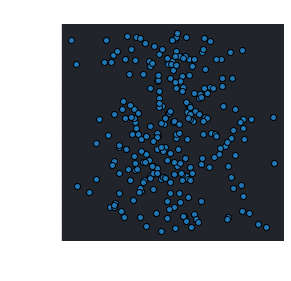

In [7]:
fig, ax = plt.subplots(figsize=[4, 4])
config = dict(edgecolor="black", linewidth=1, zorder=10)
ax.scatter(*Z.T, facecolor="tab:blue", **config)
ax.margins(0.05)
ax.set_title(r"Latent space $Z$")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
plt.show()

## Probabilistic PCA

A notable feature of these definitions of PCA (and one remarked on in many
texts) is the absence of an associated probabilistic model for the observed data. The objective
of this section is to address this limitation by demonstrating that PCA may indeed be
derived within a density estimation framework.
Chapter 12 of Bishop's [**Pattern Recognition and Machine Learning**](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) is a good reference (and a suggested reading) for latent variable models.

Generally, we can define our model in the following way:

$$
\boldsymbol x_n = \boldsymbol W \boldsymbol z_n + \boldsymbol \varepsilon_n
$$

with $\boldsymbol\varepsilon_n\sim\mathcal N(\boldsymbol 0, \sigma^2\boldsymbol I)$. 
This is also equivalent to define the following per-point likelihood: 

$$
p(\boldsymbol x_n|\boldsymbol W,\boldsymbol z_n) = \mathcal{N}( \boldsymbol W \boldsymbol z_n, \sigma^2\boldsymbol I)
$$

<!-- Under the assumption of independence, we can then write: 

$$
p(\boldsymbol X|\boldsymbol W,\boldsymbol Z) = \prod_{i=1}^N p(\boldsymbol x_n|\boldsymbol W,\boldsymbol z_n)
$$ -->

If we want to treat this model probabilistically, there are several routes we can take 
1. Place a prior on $p(\boldsymbol Z)$, and optimize the likelihood w.r.t. the values of $\boldsymbol W$ after marginalization of $\boldsymbol Z$ 
2. Place a prior on $p(\boldsymbol W)$, and optimize the likelihood w.r.t. the values of $\boldsymbol Z$ after marginalization of $\boldsymbol W$ 
3. Place a prior on $p(\boldsymbol Z)$ and $p(\boldsymbol W)$ and compute the posterior  $p(\boldsymbol Z, \boldsymbol W|\boldsymbol X)$ 

Of all the three approaches, (1) and (2) can have analytic solution, while (3) requires marginalizing both on $\boldsymbol Z$ and $\boldsymbol W$ which is generally intractable due to the non-conjugacy likelihood-prior.

### PPCA with EM

In this lab, we will focus on approch (1).

We define a Gaussian prior on $\boldsymbol z_n$ as $p(\boldsymbol z_n) = \mathcal{N}(\boldsymbol 0, \boldsymbol I)$.
While there exists a analitic solution, we will implement an iterative procedure based on Expectation-Maximization (EM).


The objective is the following
$$
\max_{\boldsymbol W} p(\boldsymbol X|\boldsymbol W,\sigma^2) = \max_{\boldsymbol W,\sigma^2} \int p(\boldsymbol X, \boldsymbol Z | \boldsymbol W,\sigma^2) \text{d}\boldsymbol Z
$$
The integral is often intractable, which motivates the use of an iterative method.
Let's start by defining the joint (log)-likelihood: 
$$
\log p(\boldsymbol X, \boldsymbol Z | \boldsymbol W,\sigma^2) = \sum_{n=1}^N \log p(\boldsymbol x_n, \boldsymbol z_n) = \sum_{n=1}^N \left[\log (\boldsymbol x_n | \boldsymbol z_n,\sigma^2) + \log p(\boldsymbol z_n)\right]
$$


In EM, we alternatively execute two steps:
1. Expectation: 
$$
f(\boldsymbol \theta;\boldsymbol \theta^{(t)}) = \mathbb{E}_{p(\boldsymbol Z | \boldsymbol X, \boldsymbol \theta^{(t)})} \log p(\boldsymbol X, \boldsymbol Z | \boldsymbol \theta)
$$
2. Maximization: 
$$
\boldsymbol \theta^{(t+1)} = \arg\max_{\boldsymbol \theta}f(\boldsymbol \theta;\boldsymbol \theta^{(t)})
$$

where, for sake of notation, $\boldsymbol \theta = \{\boldsymbol W, \sigma^2\}$.

For our problem both steps are analitical (and you encouraged to develop the expressions for expectation and for maximization).
If you trust us, they simplify in the following update rule:

$$
\boldsymbol W^{(t+1)} = \boldsymbol S\boldsymbol W (\boldsymbol M^{-1}\boldsymbol W^\top\boldsymbol S\boldsymbol W)^{-1}
$$
$$
\sigma_n^{2^{(t+1)}} = \frac 1 d \text{Tr}(\boldsymbol S - \boldsymbol S\boldsymbol W\boldsymbol M^{-1}\boldsymbol W^\top )
$$

where $\boldsymbol M =\boldsymbol W^\top\boldsymbol W + \sigma^2 I$ and $\boldsymbol S = \frac 1 N \boldsymbol X^\top\boldsymbol X$ (here both $\boldsymbol W$  and $\sigma^2$ on the RHS are to be considered at iteration $t$).

**Question**:
What is the dimensionality of $\boldsymbol W$, $\boldsymbol S$ and $\boldsymbol M$? Can you derive the complexity of these two steps?


**Exercise**: 
Implement PPCA using the EM algorithm above.

In [8]:
def PPCA_EM(X, W_init, s2_init, niter=100):
    N = X.shape[0]
    D = W_init.shape[0]
    d = X.shape[1]
    S = 1 / N * (X.T @ X)
    W, s2 = W_init, s2_init
    for _ in range(niter):
        M = W.T @ W + s2 * np.eye(W.shape[1])
        M_inv = jnp.linalg.inv(M)
        W_upd = S @ W @ jnp.linalg.inv(M_inv @ W.T @ S @ W)
        s2_upd = 1 / d * jnp.trace(S - S @ W @ M_inv @ W.T)
        W, s2 = W_upd, s2_upd
        
    return W, s2, M_inv

**Exercise**:
Think about the initial value of W. Choose `W_init` to be zeros. What do you observe?

In [9]:
W_init = np.zeros((X.shape[1], 2))
s2_init = 1
W, s2, Minv = PPCA_EM(X, W_init, s2_init)

W

DeviceArray([[nan, nan],
             [nan, nan],
             [nan, nan]], dtype=float32)

I observe there is no convergence

**Question**:
You can surely initialize W_init randomly, but what is $\boldsymbol W$ representing? What (linear algebra) properties of matrices is $\boldsymbol W$ satisfying? (*Hint*: $\boldsymbol W$ contains eigenvector). 

**Exercise**:
Then, what kind of initial values are more suited for $\boldsymbol W$? Try to implement it.

In [10]:
np.random.seed(1)
from scipy import stats

q = 2
W_init = stats.ortho_group.rvs(dim=3)[:, :q]
s2_init = 1
W, s2, Minv = PPCA_EM(X, W_init, s2_init)
W

DeviceArray([[ 4.230881  ,  1.7525321 ],
             [-1.7584877 ,  4.3884153 ],
             [-0.6057698 , -0.17120278]], dtype=float32)

Now, we need to compute the projection in the latent space. 
Note that before this projection was purely deterministic, while now it's probabilistic, i.e. we are interested in $p(\boldsymbol z|\boldsymbol x)$.
This quantity can be derived with Bayes' rule:
$$
p(\boldsymbol z|\boldsymbol x) = \mathcal{N}(\boldsymbol M^{-1} \boldsymbol W \boldsymbol x, \sigma^2 \boldsymbol M^{-1})
$$

**Exercise**: Complete the next function to project to the laten space and plot the results (use just the mean for the moment).

In [11]:
def project_latents_PPCA(X, W, s2, Minv):
    Zmean = X @ W @ Minv
    Zcov = s2 * Minv
    return Zmean, Zcov


Zmean, Zcov = project_latents_PPCA(X, W, s2, Minv)

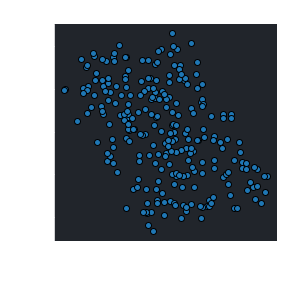

In [12]:
fig, ax = plt.subplots(figsize=[4, 4])
config = dict(edgecolor="black", linewidth=1, zorder=10)
ax.scatter(*Zmean.T, facecolor="tab:blue", **config)
ax.margins(0.05)
ax.set_title(r"Latent space $Z$")
ax.set_xlabel(r"$z_0$")
ax.set_ylabel(r"$z_1$")
plt.show()

**Exercise**:
Take just one point and plot the covariance. 

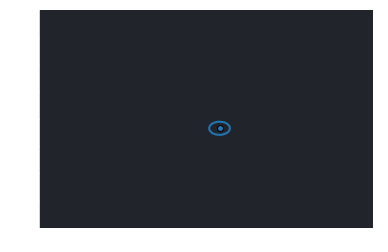

In [13]:
def plot_cov(mu, Sigma, nstd=2, label="", color="tab:blue", ax=None):
    from matplotlib.patches import Ellipse

    if ax is None:
        ax = plt.gca()

    vals, vecs = np.linalg.eigh(Sigma)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(
        xy=mu, width=width, height=height, angle=theta, fill=False, color=color, lw="2"
    )
    config = dict(edgecolor="black", linewidth=1, zorder=10)
    ax.scatter(mu[0], mu[1], facecolor="tab:blue", **config)
    ax.add_artist(ellip)
    return ellip


plot_cov(Zmean[0,:], Zcov)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

**Question**:
Is the assumption of likelihood with same variance realistic in practice? Can you think of a quick fix to relax this assumption?

A final point to note is that, at convergence, although the columns of $W$ will span the principal
subspace, they need not be orthogonal since
$$
\boldsymbol W^\top\boldsymbol W =\boldsymbol R^\top (\boldsymbol \Lambda - \sigma^2 \boldsymbol I) \boldsymbol R
$$
which is not diagonal for $\boldsymbol R \neq \boldsymbol I$. In common with other iterative PCA
algorithms, there is an element of rotational ambiguity, which means that the solution is unique up to an 
arbitrary rotation matrix $\boldsymbol R$.

However, if required, the true principal axes
may be determined by noting that the previous equation represents $\boldsymbol R$ as an eigenvector decomposition of $\boldsymbol W^\top\boldsymbol W$.

**Exercise**:
Implement a new version of the projection and take into account this additional rotation matrix $\boldsymbol R$. Plot the new results.

In [14]:
def project_latents_PPCA_rot(X, W, s2, Minv):
    q = W.shape[1]
    R = W @ W.T
    eigen_val, eigen_vect = np.linalg.eig(R)
    top_q_indices = np.argpartition(eigen_val, -q)[:q]
    W = eigen_vect[top_q_indices].T
    Zmean, Zcov = project_latents_PPCA(X, W, s2, Minv)
    return Zmean, Zcov

Zmean, Zcov = project_latents_PPCA_rot(X, W, s2, Minv)

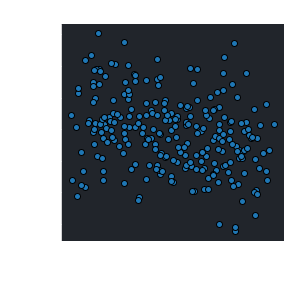

In [15]:
fig, ax = plt.subplots(figsize=[4, 4])
config = dict(edgecolor="black", linewidth=1, zorder=10)
ax.scatter(*Zmean.T, facecolor="tab:blue", **config)
ax.margins(0.05)
ax.set_title(r"Latent space $Z$")
ax.set_xlabel(r"$z_0$")
ax.set_ylabel(r"$z_1$")
plt.show()

## Projection of MNIST

As a final exercise, try to project three digits ('0', '1' and '2') from the MNIST dataset in 2 dimensions.

In [16]:
!wget https://raw.githubusercontent.com/srossi93/asi-labs/master/lab_week5-public/mnist012.npz

--2022-06-20 20:07:05--  https://raw.githubusercontent.com/srossi93/asi-labs/master/lab_week5-public/mnist012.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4720487 (4.5M) [application/octet-stream]
Saving to: ‘mnist012.npz’

mnist012.npz        100%[===================>]   4.50M  --.-KB/s    in 0.02s   

2022-06-20 20:07:05 (284 MB/s) - ‘mnist012.npz’ saved [4720487/4720487]



In [17]:
data = np.load("mnist012.npz")
X, y = data["X"], data["y"]
Ximg = X.reshape(-1, 28, 28)

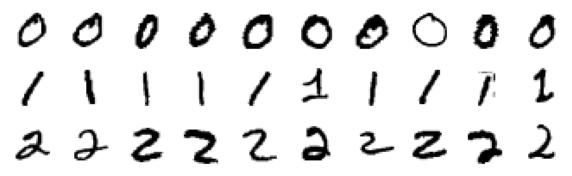

In [18]:
fig, axs = plt.subplots(3, 10, figsize=[10, 3])
for i, digit in enumerate([0, 1, 2]):
    for j, image_idx in enumerate(range(10)):
        axs[i, j].imshow(Ximg[y == digit][image_idx], cmap=plt.cm.gray_r)
        axs[i, j].axis("off")
plt.show()

**Exercise**:
Run PPCA on this data.

In [ ]:
from tqdm.notebook import tqdm

np.random.seed(0)
W_init = tqdm(stats.ortho_group.rvs(X.shape[0])[:, :2])

In [ ]:
W, s2, Minv = PPCA_EM(X, W_init, s2_init)

**Exercise**:
Compute the projections, corrected with the rotation matrix

In [ ]:
Zmean, Zcov = project_latents_PPCA(X, W, s2, Minv)

**Exercise**:
Plot the results using the function below.

In [ ]:
from matplotlib import offsetbox

config = dict(edgecolor="black", linewidth=1, alpha=0.3)


def plot_projection_mnist(Ximg, y, Z):
    shown_images = np.array([[np.inf, np.inf]])  # just something big
    for i in range(len(Z)):
        dist = np.sum((Z[i] - shown_images) ** 2, 1)
        if np.min(dist) < 0.0065:
            ## don't show points that are too close
            continue
        shown_images = np.r_[shown_images, [Z[i]]]
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(Ximg[i], zoom=0.42, cmap=plt.cm.gray_r), Z[i]
        )
        ax.add_artist(imagebox)

    # Plot also some points
    idx = np.random.permutation(len(Z))[:1000]
    ax.scatter(*Z[y == 0][idx].T, facecolor="tab:orange", **config)
    ax.scatter(*Z[y == 1][idx].T, facecolor="tab:green", **config)
    ax.scatter(*Z[y == 2][idx].T, facecolor="tab:blue", **config)


fig, ax = plt.subplots(figsize=[5, 4.5])


plot_projection_mnist(Ximg, y, Zmean)

plt.show()